# Exploratory Data Analysis: Distribution Shift Visualization

Visualize the distribution shift between CheXpert (source domain) and NIH (target domain) using UMAP projections of DenseNet121 features.

**Key questions:**
1. How separable are the two domains in feature space?
2. Do certain pathology subgroups cluster differently across domains?
3. How does the shift manifest in feature statistics?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import umap

from wcp_l2d.features import ExtractedFeatures
from wcp_l2d.pathologies import COMMON_PATHOLOGIES

plt.rcParams.update(
    {
        "figure.dpi": 120,
        "figure.facecolor": "white",
        "axes.grid": True,
        "grid.alpha": 0.3,
    }
)

## 1. Load Features

In [2]:
FEATURE_DIR = Path("../data/features")

chexpert = ExtractedFeatures.load(
    FEATURE_DIR / "chexpert_densenet121-res224-chex_features.npz"
)
nih = ExtractedFeatures.load(FEATURE_DIR / "nih_densenet121-res224-chex_features.npz")

print(
    f"CheXpert (source): {chexpert.features.shape[0]:,} samples, {chexpert.features.shape[1]} features"
)
print(
    f"NIH (target):      {nih.features.shape[0]:,} samples, {nih.features.shape[1]} features"
)

CheXpert (source): 64,534 samples, 1024 features
NIH (target):      30,805 samples, 1024 features


## 2. Basic Feature Statistics

In [3]:
print("=== Per-feature mean comparison ===")
chex_mean = chexpert.features.mean(axis=0)
nih_mean = nih.features.mean(axis=0)
print(
    f"CheXpert feature mean: {chex_mean.mean():.4f} (std across dims: {chex_mean.std():.4f})"
)
print(
    f"NIH feature mean:      {nih_mean.mean():.4f} (std across dims: {nih_mean.std():.4f})"
)

print("\n=== Per-feature std comparison ===")
chex_std = chexpert.features.std(axis=0)
nih_std = nih.features.std(axis=0)
print(
    f"CheXpert feature std: {chex_std.mean():.4f} (std across dims: {chex_std.std():.4f})"
)
print(
    f"NIH feature std:      {nih_std.mean():.4f} (std across dims: {nih_std.std():.4f})"
)

# Mean absolute difference per dimension
mean_diff = np.abs(chex_mean - nih_mean)
print(
    f"\nMean |mean_diff| across {chexpert.features.shape[1]} dims: {mean_diff.mean():.4f}"
)
print(f"Max  |mean_diff|: {mean_diff.max():.4f} (dim {mean_diff.argmax()})")

=== Per-feature mean comparison ===
CheXpert feature mean: 0.0693 (std across dims: 0.0871)
NIH feature mean:      0.0807 (std across dims: 0.1363)

=== Per-feature std comparison ===
CheXpert feature std: 0.0535 (std across dims: 0.0780)
NIH feature std:      0.0529 (std across dims: 0.0805)

Mean |mean_diff| across 1024 dims: 0.0387
Max  |mean_diff|: 0.5769 (dim 804)


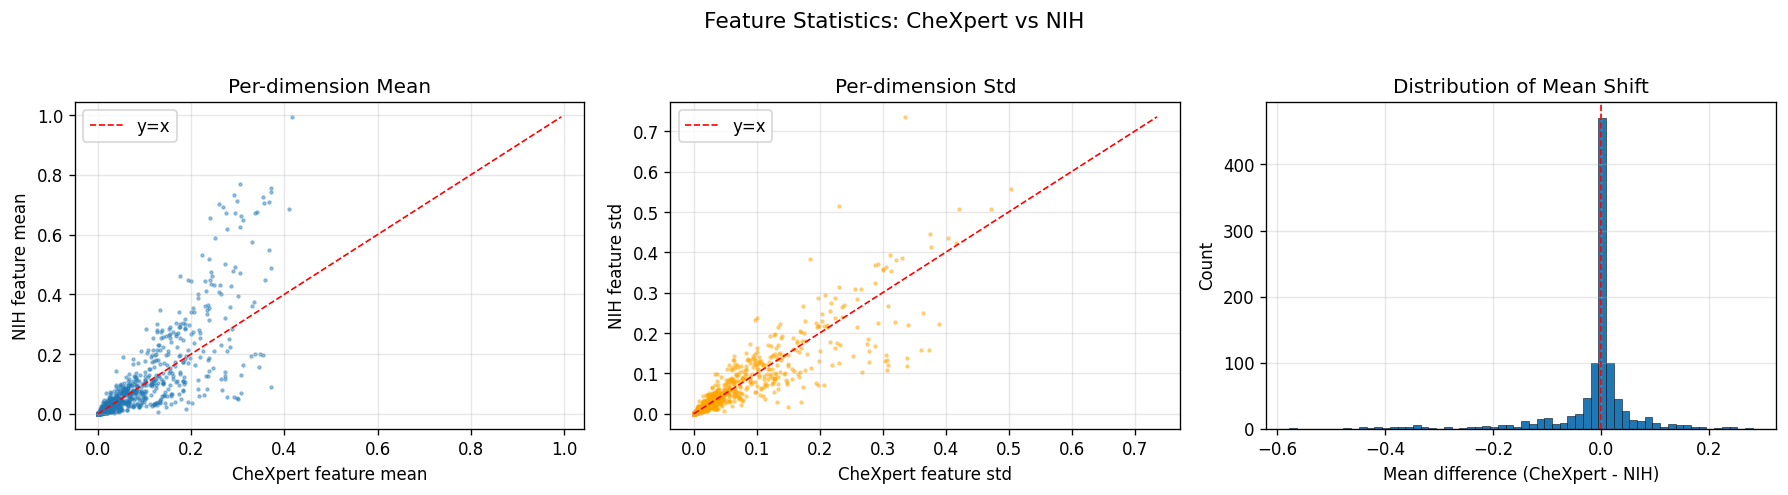

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Per-dimension mean comparison
ax = axes[0]
ax.scatter(chex_mean, nih_mean, s=3, alpha=0.4)
lim = [min(chex_mean.min(), nih_mean.min()), max(chex_mean.max(), nih_mean.max())]
ax.plot(lim, lim, "r--", linewidth=1, label="y=x")
ax.set_xlabel("CheXpert feature mean")
ax.set_ylabel("NIH feature mean")
ax.set_title("Per-dimension Mean")
ax.legend()

# Per-dimension std comparison
ax = axes[1]
ax.scatter(chex_std, nih_std, s=3, alpha=0.4, color="orange")
lim = [min(chex_std.min(), nih_std.min()), max(chex_std.max(), nih_std.max())]
ax.plot(lim, lim, "r--", linewidth=1, label="y=x")
ax.set_xlabel("CheXpert feature std")
ax.set_ylabel("NIH feature std")
ax.set_title("Per-dimension Std")
ax.legend()

# Distribution of mean differences
ax = axes[2]
ax.hist(chex_mean - nih_mean, bins=60, edgecolor="black", linewidth=0.3)
ax.axvline(0, color="r", linestyle="--", linewidth=1)
ax.set_xlabel("Mean difference (CheXpert - NIH)")
ax.set_ylabel("Count")
ax.set_title("Distribution of Mean Shift")

plt.suptitle("Feature Statistics: CheXpert vs NIH", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 3. Domain Discriminability (Proxy A-distance)

Train a logistic regression to classify CheXpert vs NIH samples. High accuracy indicates large distribution shift.

In [5]:
# Create domain labels: 0=CheXpert, 1=NIH
X_all = np.concatenate([chexpert.features, nih.features], axis=0)
y_domain = np.concatenate(
    [
        np.zeros(len(chexpert.features)),
        np.ones(len(nih.features)),
    ]
)

# Subsample for speed
rng = np.random.RandomState(42)
n_sub = 10_000
idx = rng.choice(len(X_all), size=min(n_sub, len(X_all)), replace=False)
X_sub, y_sub = X_all[idx], y_domain[idx]

# Standardize
scaler = StandardScaler()
X_sub = scaler.fit_transform(X_sub)

# Train/test split
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    X_sub, y_sub, test_size=0.3, random_state=42, stratify=y_sub
)

clf = LogisticRegression(max_iter=1000, solver="lbfgs", random_state=42)
clf.fit(X_tr, y_tr)

acc = clf.score(X_te, y_te)
probs = clf.predict_proba(X_te)[:, 1]
auc = roc_auc_score(y_te, probs)
proxy_a_dist = 2 * (1 - 2 * (1 - acc))  # Proxy A-distance

print(f"Domain classifier accuracy: {acc:.4f}")
print(f"Domain classifier AUC:      {auc:.4f}")
print(f"Proxy A-distance:           {proxy_a_dist:.4f}")
print(f"\n(Chance = 0.5, perfect = 1.0. Higher = larger shift)")

Domain classifier accuracy: 0.9990
Domain classifier AUC:      1.0000
Proxy A-distance:           1.9960

(Chance = 0.5, perfect = 1.0. Higher = larger shift)


## 4. UMAP Visualization: Source vs Target Domain

In [6]:
# Subsample for UMAP (balanced between domains)
n_per_domain = 5000
rng = np.random.RandomState(42)

idx_chex = rng.choice(
    len(chexpert.features),
    size=min(n_per_domain, len(chexpert.features)),
    replace=False,
)
idx_nih = rng.choice(
    len(nih.features), size=min(n_per_domain, len(nih.features)), replace=False
)

X_umap = np.concatenate([chexpert.features[idx_chex], nih.features[idx_nih]], axis=0)
labels_umap = np.concatenate([chexpert.labels[idx_chex], nih.labels[idx_nih]], axis=0)
domain_labels = np.array(["CheXpert"] * len(idx_chex) + ["NIH"] * len(idx_nih))

# Standardize before UMAP
scaler = StandardScaler()
X_umap_scaled = scaler.fit_transform(X_umap)

print(
    f"UMAP input: {X_umap_scaled.shape[0]:,} samples ({len(idx_chex):,} CheXpert + {len(idx_nih):,} NIH)"
)
print("Running UMAP (this may take a minute)...")

UMAP input: 10,000 samples (5,000 CheXpert + 5,000 NIH)
Running UMAP (this may take a minute)...


In [7]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42,
)

embedding = reducer.fit_transform(X_umap_scaled)
print(f"UMAP embedding shape: {embedding.shape}")

UMAP embedding shape: (10000, 2)


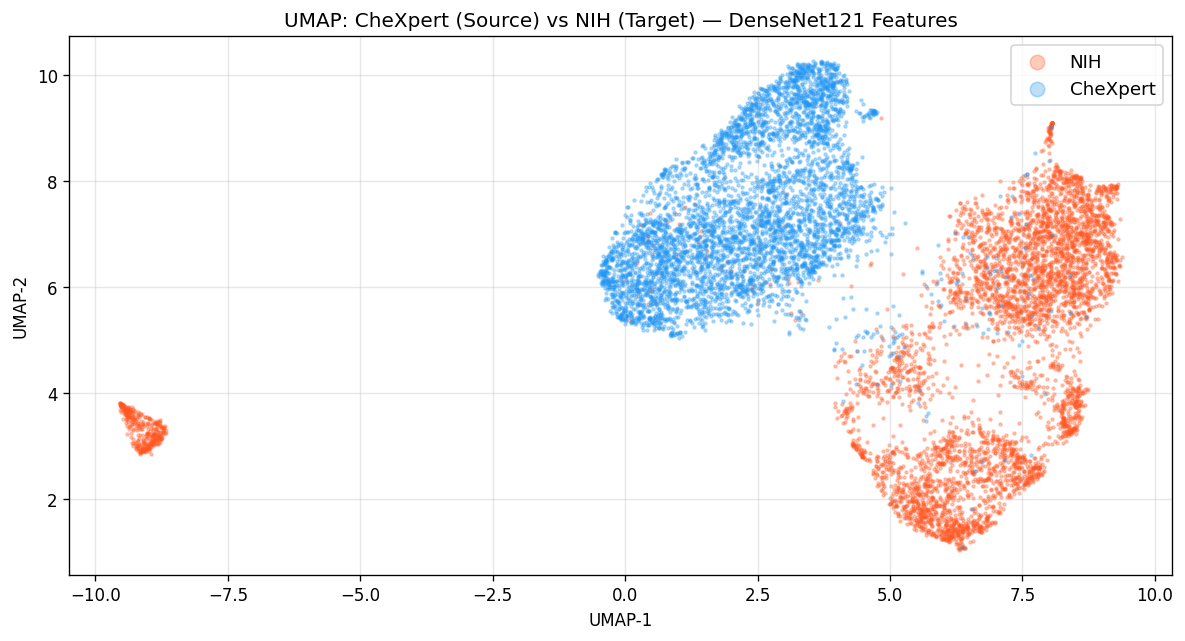

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = {"CheXpert": "#2196F3", "NIH": "#FF5722"}

for domain in ["NIH", "CheXpert"]:  # plot NIH first so CheXpert is on top
    mask = domain_labels == domain
    ax.scatter(
        embedding[mask, 0],
        embedding[mask, 1],
        s=3,
        alpha=0.3,
        label=domain,
        color=colors[domain],
        rasterized=True,
    )

ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_title("UMAP: CheXpert (Source) vs NIH (Target) — DenseNet121 Features")
ax.legend(markerscale=5, fontsize=11)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## 5. UMAP Colored by Pathology

Overlay pathology labels on the UMAP to see if disease subgroups shift differently.

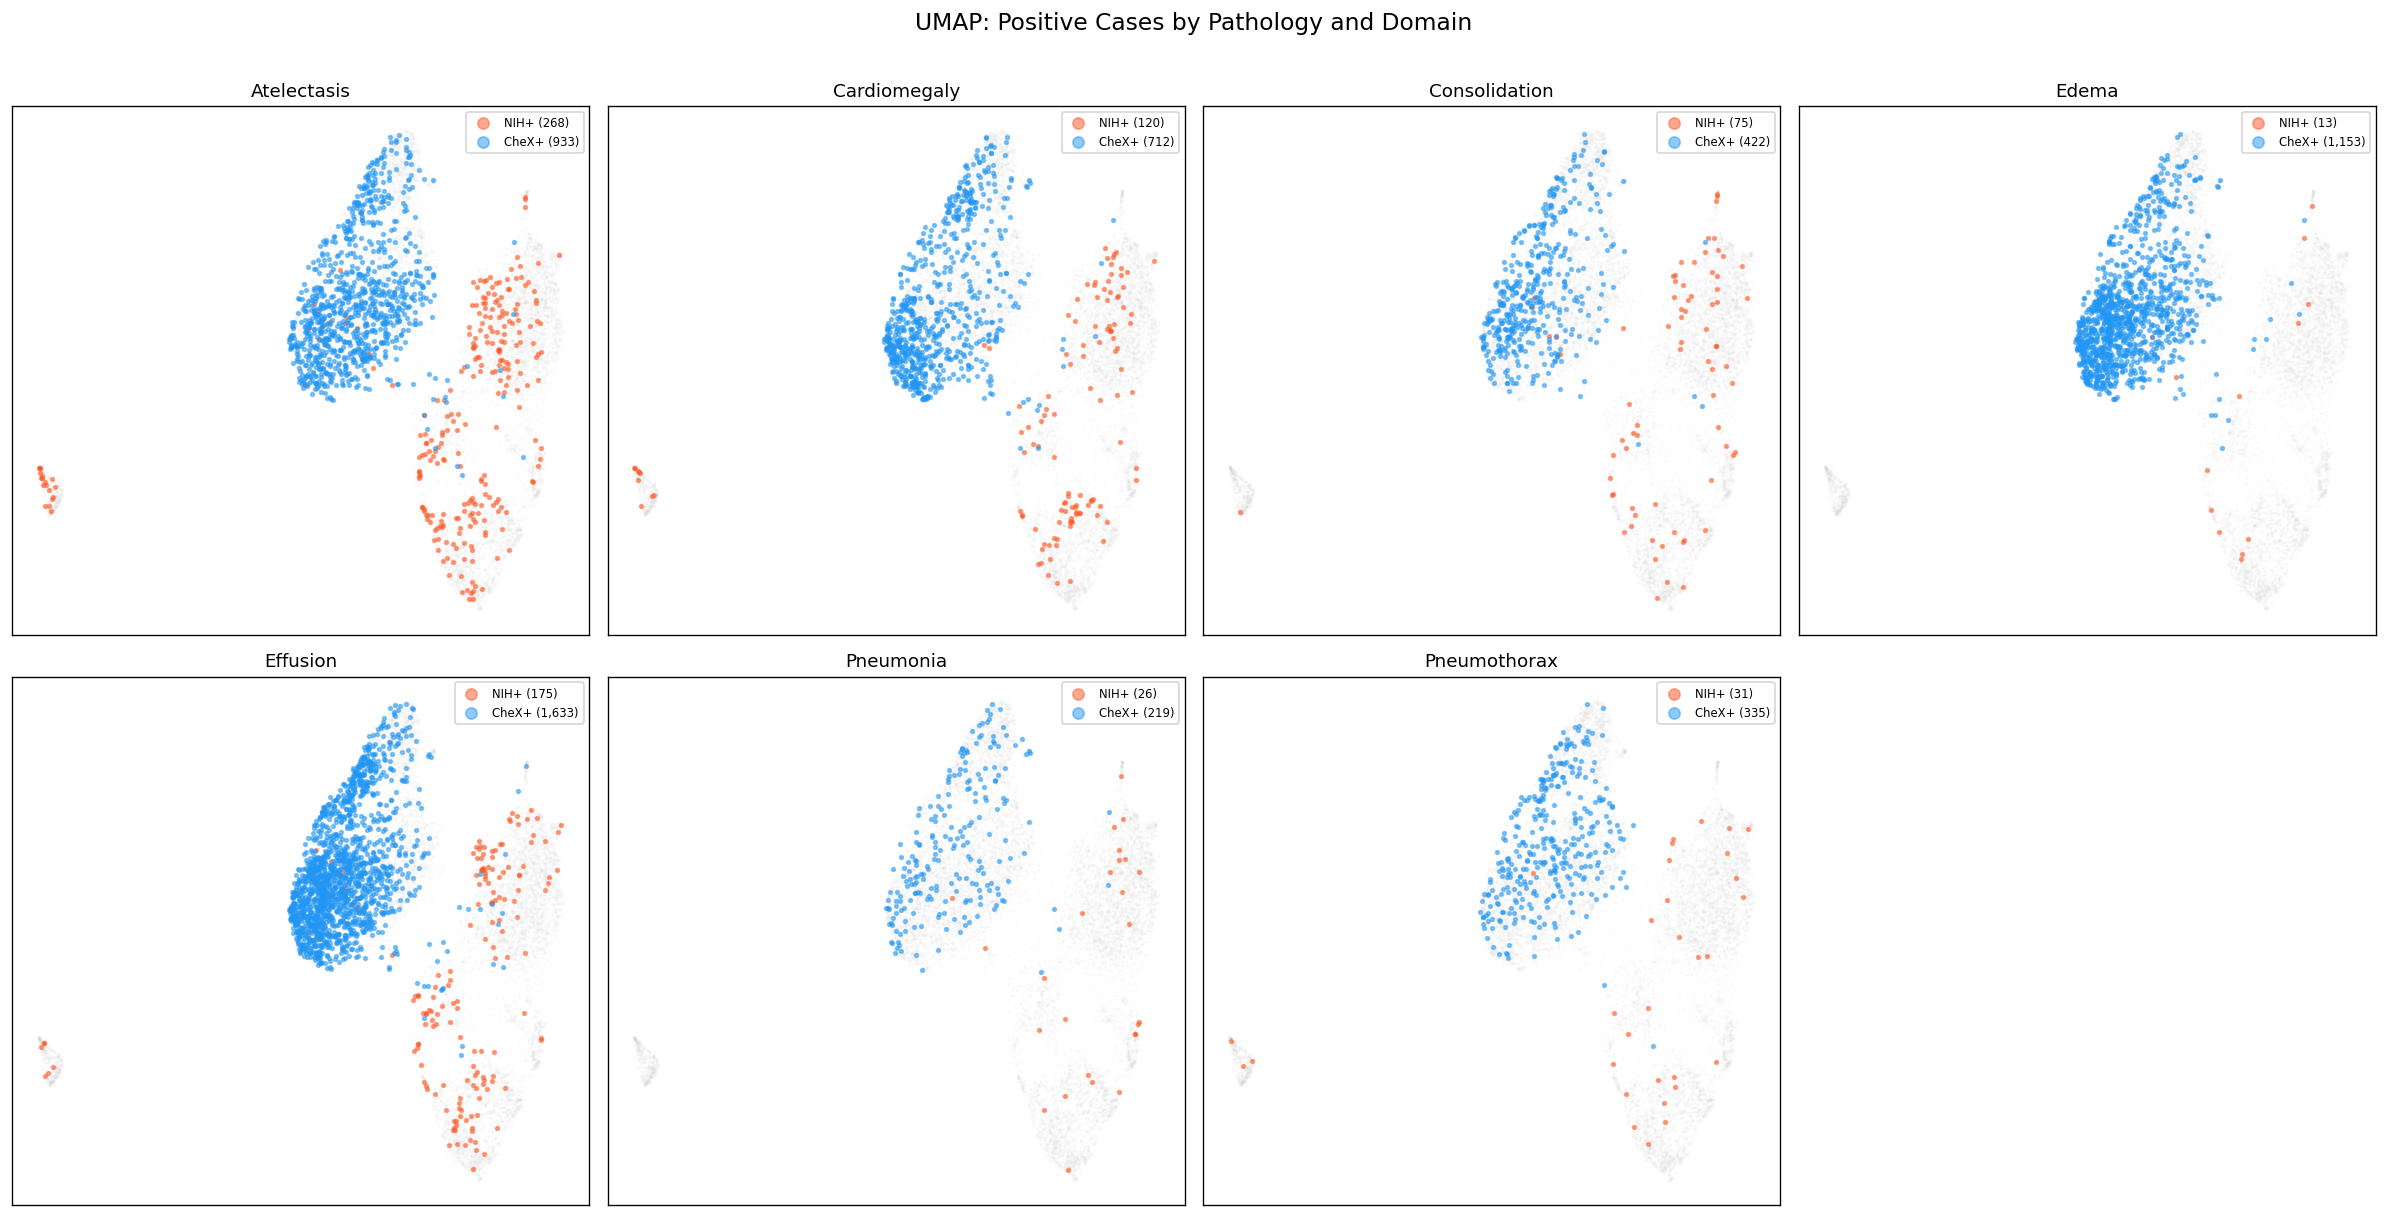

In [9]:
n_pathologies = len(COMMON_PATHOLOGIES)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, pathology in enumerate(COMMON_PATHOLOGIES):
    ax = axes[i]
    y = labels_umap[:, i]

    # Background: all samples in gray
    ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        alpha=0.05,
        color="lightgray",
        rasterized=True,
    )

    # Positive samples colored by domain
    pos_chex = (y == 1) & (domain_labels == "CheXpert")
    pos_nih = (y == 1) & (domain_labels == "NIH")

    if pos_nih.sum() > 0:
        ax.scatter(
            embedding[pos_nih, 0],
            embedding[pos_nih, 1],
            s=5,
            alpha=0.5,
            color="#FF5722",
            label=f"NIH+ ({pos_nih.sum():,})",
            rasterized=True,
        )
    if pos_chex.sum() > 0:
        ax.scatter(
            embedding[pos_chex, 0],
            embedding[pos_chex, 1],
            s=5,
            alpha=0.5,
            color="#2196F3",
            label=f"CheX+ ({pos_chex.sum():,})",
            rasterized=True,
        )

    ax.set_title(pathology, fontsize=11)
    ax.legend(fontsize=7, markerscale=3, loc="upper right")
    ax.set_xticks([])
    ax.set_yticks([])

# Hide the unused subplot
axes[-1].axis("off")

plt.suptitle("UMAP: Positive Cases by Pathology and Domain", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 6. Feature Norm Distribution

Compare L2 norm distributions — a simple but effective shift indicator.

CheXpert norms: mean=4.56, std=1.03
NIH norms:      mean=5.74, std=1.50


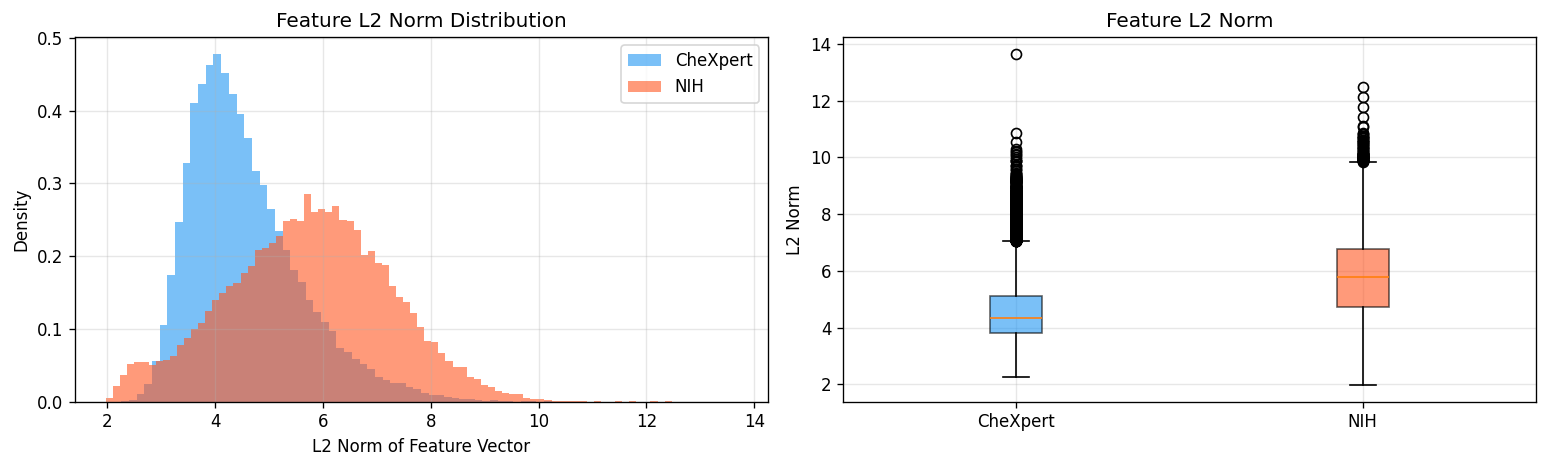

In [10]:
chex_norms = np.linalg.norm(chexpert.features, axis=1)
nih_norms = np.linalg.norm(nih.features, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Histogram
ax = axes[0]
ax.hist(chex_norms, bins=80, alpha=0.6, label="CheXpert", color="#2196F3", density=True)
ax.hist(nih_norms, bins=80, alpha=0.6, label="NIH", color="#FF5722", density=True)
ax.set_xlabel("L2 Norm of Feature Vector")
ax.set_ylabel("Density")
ax.set_title("Feature L2 Norm Distribution")
ax.legend()

# Box plot
ax = axes[1]
bp = ax.boxplot(
    [chex_norms, nih_norms],
    labels=["CheXpert", "NIH"],
    patch_artist=True,
)
bp["boxes"][0].set_facecolor("#2196F3")
bp["boxes"][1].set_facecolor("#FF5722")
for box in bp["boxes"]:
    box.set_alpha(0.6)
ax.set_ylabel("L2 Norm")
ax.set_title("Feature L2 Norm")

print(f"CheXpert norms: mean={chex_norms.mean():.2f}, std={chex_norms.std():.2f}")
print(f"NIH norms:      mean={nih_norms.mean():.2f}, std={nih_norms.std():.2f}")

plt.tight_layout()
plt.show()

## 7. UMAP Colored by Feature Norm

Overlay feature norm on the UMAP to see if norm variation correlates with domain separation.

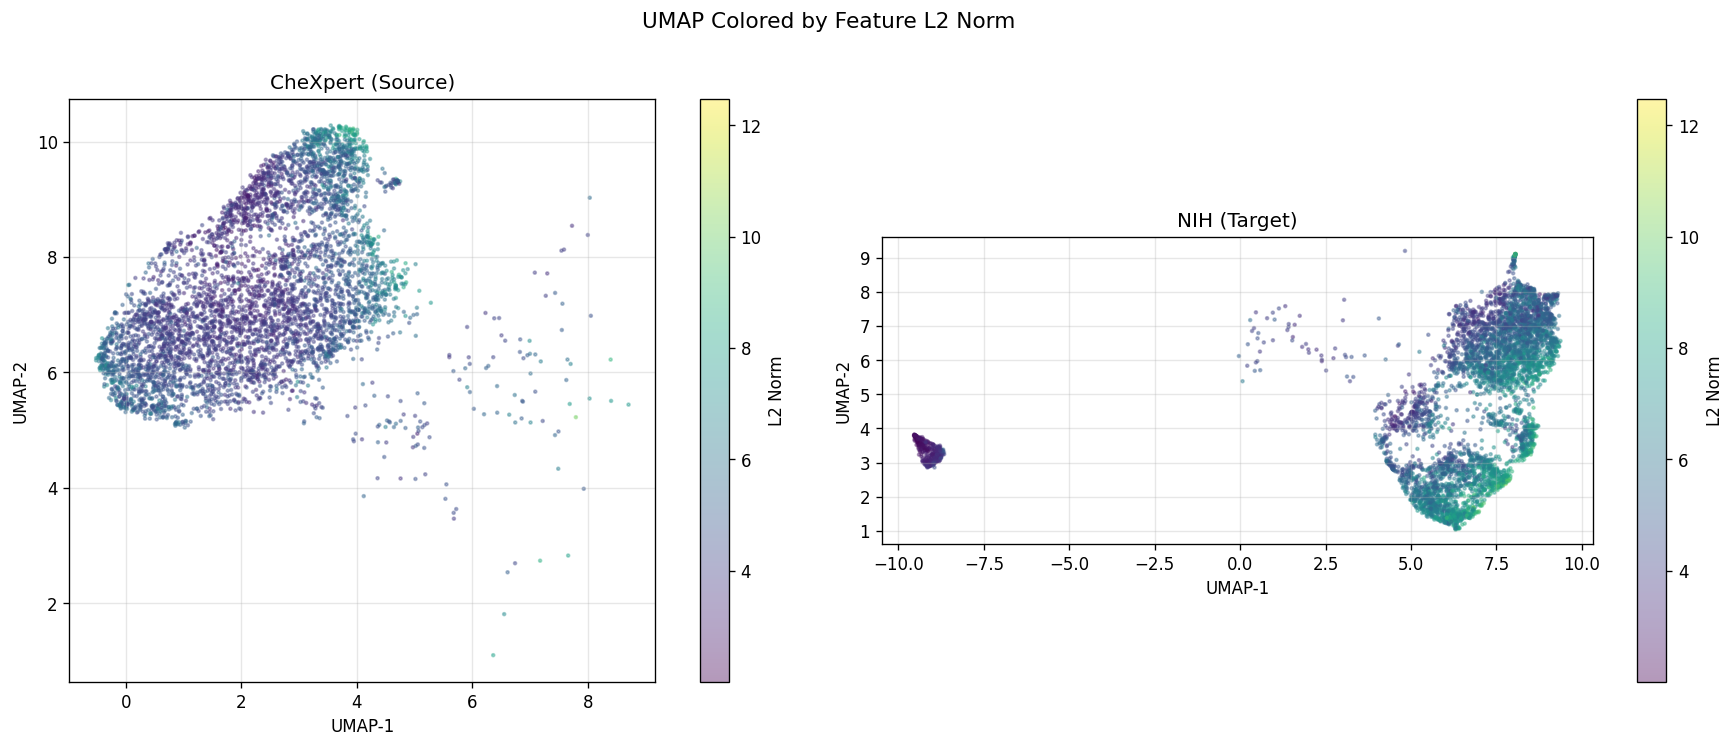

In [11]:
norms_umap = np.linalg.norm(X_umap, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, domain, title in zip(
    axes, ["CheXpert", "NIH"], ["CheXpert (Source)", "NIH (Target)"]
):
    mask = domain_labels == domain
    sc = ax.scatter(
        embedding[mask, 0],
        embedding[mask, 1],
        c=norms_umap[mask],
        s=3,
        alpha=0.4,
        cmap="viridis",
        vmin=norms_umap.min(),
        vmax=norms_umap.max(),
        rasterized=True,
    )
    ax.set_title(title)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_aspect("equal")
    plt.colorbar(sc, ax=ax, label="L2 Norm")

plt.suptitle("UMAP Colored by Feature L2 Norm", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 8. Label Prevalence Comparison

Distribution shift can also manifest as label shift. Compare prevalence rates.

In [12]:
prevalence = []
for i, pathology in enumerate(COMMON_PATHOLOGIES):
    chex_y = chexpert.labels[:, i]
    nih_y = nih.labels[:, i]

    chex_valid = ~np.isnan(chex_y)
    nih_valid = ~np.isnan(nih_y)

    prevalence.append(
        {
            "Pathology": pathology,
            "CheXpert_prevalence": chex_y[chex_valid].mean()
            if chex_valid.any()
            else np.nan,
            "CheXpert_n_labeled": int(chex_valid.sum()),
            "NIH_prevalence": nih_y[nih_valid].mean() if nih_valid.any() else np.nan,
            "NIH_n_labeled": int(nih_valid.sum()),
        }
    )

df_prev = pd.DataFrame(prevalence)
df_prev["prevalence_ratio"] = df_prev["CheXpert_prevalence"] / df_prev["NIH_prevalence"]
df_prev

,Pathology,CheXpert_prevalence,CheXpert_n_labeled,NIH_prevalence,NIH_n_labeled,prevalence_ratio
0,Atelectasis,0.469898,27008,0.054050,30805,8.693815
1,Cardiomegaly,0.338706,26864,0.025223,30805,13.428366
2,Consolidation,0.193232,27894,0.014154,30805,13.652516
3,Edema,0.420015,35544,0.002532,30805,165.878845
4,Effusion,0.467603,44140,0.040253,30805,11.616543
5,Pneumonia,0.160204,17615,0.005648,30805,28.362617
6,Pneumothorax,0.116526,36996,0.008180,30805,14.244393


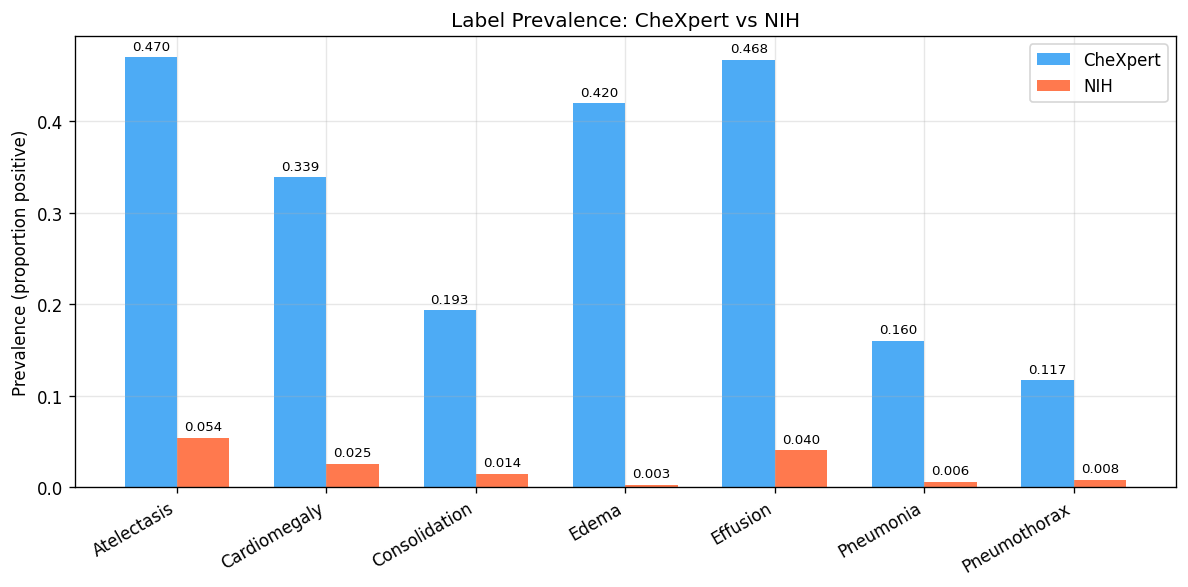

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(COMMON_PATHOLOGIES))
width = 0.35

bars1 = ax.bar(
    x - width / 2,
    df_prev["CheXpert_prevalence"],
    width,
    label="CheXpert",
    color="#2196F3",
    alpha=0.8,
)
bars2 = ax.bar(
    x + width / 2,
    df_prev["NIH_prevalence"],
    width,
    label="NIH",
    color="#FF5722",
    alpha=0.8,
)

ax.set_ylabel("Prevalence (proportion positive)")
ax.set_title("Label Prevalence: CheXpert vs NIH")
ax.set_xticks(x)
ax.set_xticklabels(COMMON_PATHOLOGIES, rotation=30, ha="right")
ax.legend()

for bar in bars1:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.005,
        f"{bar.get_height():.3f}",
        ha="center",
        va="bottom",
        fontsize=8,
    )
for bar in bars2:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.005,
        f"{bar.get_height():.3f}",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.show()

## 9. UMAP with KDE Density Contours

Overlay kernel density contours to highlight regions where each domain concentrates.

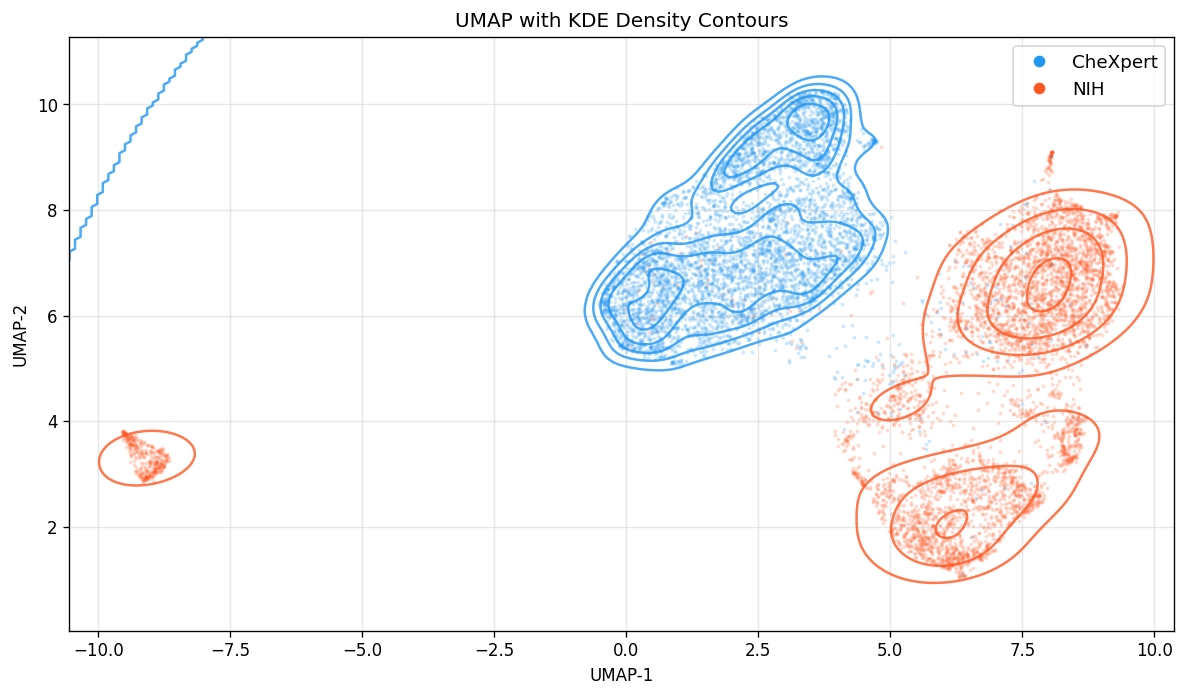

In [14]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(figsize=(10, 8))

# Scatter background
for domain, color in [("NIH", "#FF5722"), ("CheXpert", "#2196F3")]:
    mask = domain_labels == domain
    ax.scatter(
        embedding[mask, 0],
        embedding[mask, 1],
        s=2,
        alpha=0.15,
        color=color,
        rasterized=True,
    )

# KDE contours
for domain, color in [("CheXpert", "#2196F3"), ("NIH", "#FF5722")]:
    mask = domain_labels == domain
    xy = embedding[mask].T
    kde = gaussian_kde(xy, bw_method=0.2)

    xmin, xmax = embedding[:, 0].min() - 1, embedding[:, 0].max() + 1
    ymin, ymax = embedding[:, 1].min() - 1, embedding[:, 1].max() + 1
    xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

    ax.contour(xx, yy, zz, levels=5, colors=color, linewidths=1.5, alpha=0.8)

# Legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="#2196F3",
        markersize=8,
        label="CheXpert",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="#FF5722",
        markersize=8,
        label="NIH",
    ),
]
ax.legend(handles=legend_elements, fontsize=11)
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_title("UMAP with KDE Density Contours")
ax.set_aspect("equal")

plt.tight_layout()
plt.show()

## 10. Summary

Key observations from this EDA:

1. **Domain separability**: The proxy A-distance and domain classifier AUC quantify how distinguishable the two domains are in feature space.
2. **UMAP structure**: The 2D projection reveals whether CheXpert and NIH form distinct clusters or overlap significantly.
3. **Pathology-specific shift**: Different diseases may shift differently — some pathologies may cluster together across domains while others separate.
4. **Feature norm shift**: Differences in L2 norm distributions suggest covariate shift in the activation magnitudes.
5. **Label prevalence shift**: Differences in disease prevalence contribute to the overall distribution shift.

These findings motivate the use of **Weighted Conformal Prediction (WCP)** with density ratio estimation to adapt predictions from CheXpert to NIH.